
Inregistrati in Audacity vocala a a propriei voci cu fs=16kHz.
Se cere sa se implementeze analiza LPC folsind durata cadrului de 30 ms, 
ordin de predictie 18, si sa se afiseze si interpreteze rezultatele pentru:

a) coef LPC din  cadrul 5 de vorbire

In [ ]:
#[a, b, c, d] = [wav_struct.getframerate(), wav_struct.getsampwidth(), wav_struct.getnchannels(), wav_struct.getnframes()]


In [ ]:
#import biblioteci
import wave
import numpy as np
import librosa.core as lb
from scipy.signal import hamming
import matplotlib.pylab as pl
from scipy.signal import freqz

input_wav_vowel = 'speech_files/a.wav'
wav_struct_vowel = wave.open(input_wav_vowel, 'r')
sampling_frequency = wav_struct_vowel.getframerate()
wav_bytes_vowel = wav_struct_vowel.readframes(-1)
wav_data_vowel = np.frombuffer(wav_bytes_vowel, dtype='int16')
wav_data_vowel = wav_data_vowel/float(max(abs(wav_data_vowel)))
wav_struct_vowel.close()

#lungime fereastra
window_length = int(30*1e-3*sampling_frequency)

window_fft = int(2**np.ceil(np.log2(window_length)))
hamming_window = hamming(window_fft)

k = 5
current_frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
hamming_frame = np.multiply(hamming_window, current_frame)

lpc_order=18
a = lb.lpc(hamming_frame, lpc_order)
print(a)

[ 1.         -2.58925108  2.67025365 -1.87779785  2.23207164 -2.97519328
  2.76771722 -2.27828871  2.43622556 -2.54407233  2.45698019 -2.78976941
  2.69345429 -1.78960607  1.2602281  -1.32106787  1.10075916 -0.46840948
  0.04730533]


b) determinarea primilor 3 formanti f1, f2, f3 din cadrul 6 de vorbire

In [ ]:
def extract_formants(input_sample, lpc_order, fs):
    a = lb.lpc(input_sample,lpc_order)
    
    # Extragem rădăcinile polinomului dat de
    # coeficienții LPC
    roots = np.roots(a)
    
    # Rădăcinile sunt complex conjugate, reținem doar
    # o valoare din pereche
    roots = roots[np.where(np.imag(roots) > 0)]
    
    # Calculăm fazele rădăcinilor
    angles = np.arctan2(np.imag(roots), np.real(roots))
    
    # Calculăm frecvențele
    freqs = angles * (fs / (2 * np.pi))
    
    # Reordonăm în ordinea crescătoare a fazelor
    frequency_indices = np.argsort(freqs)
    formants = [int(x) for x in freqs[frequency_indices]]
    # Benzile de frecvență ale formanților
    # sunt date de distanța polilor față de
    # cercul unitate
    bw = -1 / 2 * (fs / (2 * np.pi)) * np.log(np.abs(roots[frequency_indices]))
    # Frecvențele formanților trebuie să
    # fie mai mari decât 90Hz cu o bandă
    # de frecvențe mai mică de 400Hz
    formants = [f for i,f in enumerate(formants) \
                if f>90 and bw[i]<400]
    return formants[:3]

# Extragem valorile formanților dintr-un cadru al vocalei
k = 2
current_frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
hamming_frame = np.multiply(hamming_window, current_frame)
lpc_order=18
a = lb.lpc(hamming_frame, lpc_order)
formants = extract_formants(hamming_frame, lpc_order, sampling_frequency)
print ("Formant values: "+' '.join([str(x)+'Hz' for x in formants]) )



Formant values: 742Hz 1207Hz 2226Hz


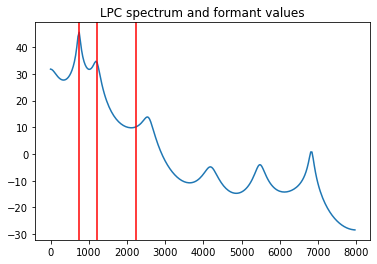

In [ ]:
#afisare
# Obținem răspunsul în frecvență al filtrului dat de
# coeficienții LPC. Lungimea răspunsului o luăm egală
# cu numărul de puncte FFT al spectrului semnalului
w, h = freqz(1, a , window_fft//2)
# Axa frecvenței
freq_axis = np.arange(window_fft//2)*sampling_frequency/window_fft
# Plot spectrul LPC
pl.plot(freq_axis, 20*np.log10(abs(h)))


for f in formants:
    pl.axvline(f, color = 'r')    
pl.title("LPC spectrum and formant values");

c) sa se sintetizeze cadrul 5 de vorbire din impulsuri Dirac si sa se afiseze pe acelasi grafic semnalul original si semnalul sintetizat

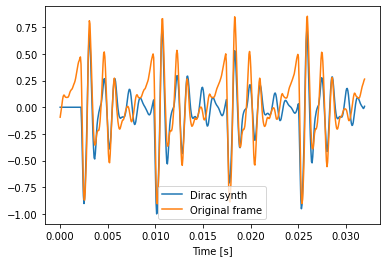

In [ ]:
from scipy.signal import lfilter
from scipy.signal import find_peaks

k = 5
frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
a = lb.lpc(frame, lpc_order)
# Creăm setul de coeficienți pentru filtrul invers
a_hat =  -1*a
a_hat[0] = 0

# Filtrăm cu filtrul invers
y_hat = lfilter(a_hat, 1, frame)

# Calculăm eroarea
err = frame - y_hat
# Eroarea pătratică
err_square = abs(err)

peaks,_ = find_peaks(err_square[20:], distance=90)

# Corectăm indecșii returnați
peaks = peaks+20

# Vector pentru sursa Dirac
dirac_source = np.zeros(window_fft)
dirac_source[peaks] = err[peaks]
# Filtrăm sursa Dirac cu filtrul LPC:
dirac_synth = lfilter([1.],a, dirac_source)
# Normalizăm pentru că nu am calculat
# câștigul filtrului LPC
dirac_synth = dirac_synth/(max(abs(dirac_synth)))

# Plot
time_axis = np.arange(0, window_fft)*1.00/sampling_frequency
pl.plot(time_axis, dirac_synth)
pl.plot(time_axis, frame)
pl.xlabel("Time [s]")
pl.legend(["Dirac synth", "Original frame"]);

In [ ]:
# Repetăm cadrul pentru a putea auzi rezultatul
dirac_synth_long = np.tile(dirac_synth, 3)

# Ascultăm sinteza
import IPython
IPython.display.Audio(dirac_synth_long, rate=sampling_frequency)

In [ ]:
# Ascultăm și semnalul original
IPython.display.Audio(wav_data_vowel, rate=sampling_frequency)

d) afisati spectrul LPC aferent cadrului 6 de vorbire si comentati rezultatul

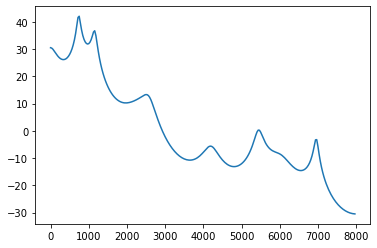

In [ ]:
k = 6
current_frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
hamming_frame = np.multiply(hamming_window, current_frame)
lpc_order=18
a = lb.lpc(hamming_frame, lpc_order)
#afisare
# Obținem răspunsul în frecvență al filtrului dat de
# coeficienții LPC. Lungimea răspunsului o luăm egală
# cu numărul de puncte FFT al spectrului semnalului
w, h = freqz(1, a , window_fft//2)
# Axa frecvenței
freq_axis = np.arange(window_fft//2)*sampling_frequency/window_fft
# Plot spectrul LPC
pl.plot(freq_axis, 20*np.log10(abs(h)))

e) faceti analiza LPC la toate cadrele si afisati pe 2 grafice distincte
	1)ev. coef a2 de la cadu la cadru
	2)ev. coef a10 de la cadru la cadru

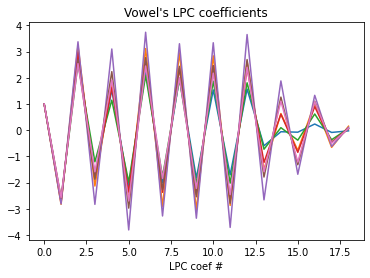

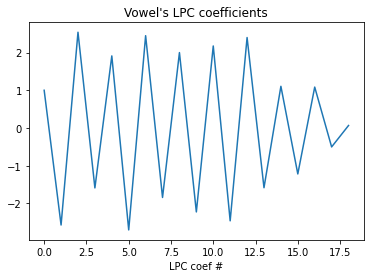

In [ ]:
import librosa.core as lb
from scipy.signal import hamming
import matplotlib.pylab as pl
%matplotlib inline

# Fereastra de analiză cu lungime egală cu putere a lui 2 fără suprapunere
window_length = int(20*1e-3*sampling_frequency)
window_fft = int(2**np.ceil(np.log2(window_length)))
p = 0
# Fereastră Hamming
hamming_window = hamming(window_fft)

# Numărul de cadre
number_of_frames = int(len(wav_data_vowel)/window_fft)

# Stabilim ordinul LPC la Fs + 2
lpc_order = sampling_frequency//1000 + 2

# Inițializăm o matrice nulă în care vom stoca valorile
# coeficienților LPC din fiecare cadru. Numărul
# de coeficienți LPC returnat de funcție este egal
# cu ordinul LPC+1 datorită termenului liber
lpcs = np.zeros ([number_of_frames, lpc_order+1])
for k in range(number_of_frames):
    current_frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
    hamming_frame = np.multiply(hamming_window, current_frame)
    lpcs[k,:] = lb.lpc(hamming_frame, lpc_order)
    

# Plot
pl.plot(np.transpose(lpcs))
pl.title("Vowel's LPC coefficients")
pl.xlabel('LPC coef #');
pl.figure()
pl.plot(np.transpose(lpcs[6]))
pl.title("Vowel's LPC coefficients")
pl.xlabel('LPC coef #');

f) pentru coef a10 afisati histograma pentru toate cadrele

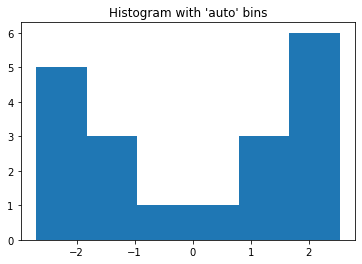

In [ ]:
#x=np.histogram(np.transpose(lpcs[6], bins=100, range=None, normed=None, weights=None, density=None)
import matplotlib.pyplot as plt
_= plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

g) realizati sinteza LPC pentru cadrul 5 folosind la intrare eroarea de predictie (nu impulsuri Dirac). CE OBSERVATI? 

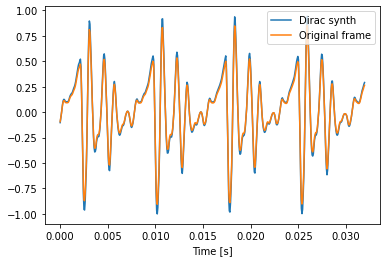

In [ ]:
from scipy.signal import lfilter
from scipy.signal import find_peaks

k = 5
frame = wav_data_vowel[k*window_fft: (k+1)*window_fft]
a = lb.lpc(frame, lpc_order)
# Creăm setul de coeficienți pentru filtrul invers
a_hat =  -1*a
a_hat[0] = 0

# Filtrăm cu filtrul invers
y_hat = lfilter(a_hat, 1, frame)

# Calculăm eroarea
err = frame - y_hat
# Eroarea pătratică
err_square = abs(err)

peaks,_ = find_peaks(err_square[20:], distance=90)

# Corectăm indecșii returnați
peaks = peaks+20

synth = lfilter([1.],a, err)
# Normalizăm pentru că nu am calculat
# câștigul filtrului LPC
synth = synth/(max(abs(synth)))

# Plot
time_axis = np.arange(0, window_fft)*1.00/sampling_frequency
pl.plot(time_axis, synth)
pl.plot(time_axis, frame)
pl.xlabel("Time [s]")
pl.legend(["Dirac synth", "Original frame"]);

=>semnalul este sinteztizat perfect=>>sinteza perfecta